### We work only with jpg images

In [1]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

import os
import glob
import pickle
from time import time
from functools import partial
from multiprocessing import Pool, cpu_count

from skimage.segmentation import slic
from skimage.transform import rescale
from skimage.io import imread, imshow
from skimage.color import rgb2grey, rgb2luv

In [54]:
# Constants
IMG_PATH = "./Images"
VERBOSE = True
REWRITE = True
N_PROCESSES = cpu_count()

N_SEGMENTS = 200
IMG_WIDTH = 500
IMG_HEIGHT = 500
PATCH_WIDTH = 10
PATCH_HEIGHT = 10

SLIC_EXT = ".slic.npy"
CENT_EXT = ".cent.npy"
FEAT_EXT = ".feat.npy"

In [4]:
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        print("Finished %s in %d seconds" % (func.__name__, time() - start_time))
        return result
    return wrapper

In [41]:
# return the original image and its segmentation
def get_data(img_path, n_segments=N_SEGMENTS, rewrite=REWRITE):
    img = imread(img_path)
    scale_factor = min(IMG_HEIGHT/img.shape[0], IMG_WIDTH/img.shape[1])
    img = rescale(img, scale_factor)
    slic_path = img_path + SLIC_EXT

    if not os.path.exists(slic_path) or rewrite:
        img_grey = (rgb2grey(img) * 255).astype("uint8")
        img_slic = slic(img_grey, n_segments=n_segments, compactness=0.1, enforce_connectivity=True)
        np.save(slic_path, img_slic)
    else:
        img_slic = np.load(slic_path)

    return img, img_slic

In [52]:
# return the centroids and their average U and V channels values
def get_centroids(img_path, segments, img_luv, rewrite=REWRITE):
    cent_path = img_path + CENT_EXT
    
    if VERBOSE:
        print("Calculating centroids for %s" % img_path)

    if not os.path.exists(cent_path) or rewrite:
        n_segments = segments.max() + 1
        pixel_count = np.zeros(n_segments, dtype='uint')
        centroids = np.zeros((n_segments, 2), dtype='uint')
        U = np.zeros(n_segments)
        V = np.zeros(n_segments)

        # accumulate values
        for (i,j), value in np.ndenumerate(segments):
            pixel_count[value] += 1
            centroids[value][0] += i
            centroids[value][1] += j
            U[value] += img_luv[i][j][1]
            V[value] += img_luv[i][j][2]

        # average values
        centroids = (centroids.T // pixel_count).T
        U //= pixel_count
        V //= pixel_count

        cent_dict = {}
        cent_dict['centroids'], cent_dict['U'], cent_dict['V'] = centroids, U, V
        np.save(cent_path, cent_dict)
    else:
        cent_dict = np.load(cent_path).item()
        centroids, U, V = cent_dict['centroids'], cent_dict['U'], cent_dict['V']

    return centroids, U, V 

In [7]:
# return the corresponding patch for centroid
def get_patch(centroid, img):
    patch = np.zeros((PATCH_HEIGHT, PATCH_WIDTH))
    top = max(centroid[0] - PATCH_HEIGHT//2, 0)
    left = max(centroid[1] - PATCH_WIDTH//2, 0)
    bottom = min(centroid[0] + (PATCH_HEIGHT - 1)//2, img.shape[0]-1) + 1
    right = min(centroid[1] + (PATCH_WIDTH - 1)//2, img.shape[1]-1) + 1
    patch[:(bottom-top), :(right-left)] = img[top:bottom, left:right, 0]
    return patch

In [55]:
# retrieves feature vectors and their corresponding values
def extract_features(img_path, rewrite=REWRITE):
    feat_path = img_path + FEAT_EXT
    
    if not os.path.exists(feat_path) or rewrite:
        img, segments = get_data(img_path)
        img_luv = rgb2luv(img)
        n_segments = segments.max() + 1

        centroids, U, V = get_centroids(img_path, segments, img_luv)

        if VERBOSE:
            print("Calculating features for %s" % img_path)

        f = lambda x : np.fft.fft2(get_patch(x, img_luv)).reshape(PATCH_HEIGHT*PATCH_WIDTH)
        features = np.array([f(centroid) for centroid in centroids])

        feat_dict = {}
        feat_dict['features'], feat_dict['U'], feat_dict['V'] = features, U, V
        np.save(feat_path, feat_dict)
    else:
        feat_dict = np.load(feat_path).item()
        features, U, V = feat_dict['centroids'], feat_dict['U'], feat_dict['V']

    return features, U, V

In [44]:
@timeit
def main():
    img_files = glob.glob(os.path.join(IMG_PATH, "*.jpg"))
    with Pool(N_PROCESSES) as pool:
        pool.map(extract_features, img_files, chunksize=5)

In [46]:
img, segments = get_data("./Images/01-BxUGs88xBck.jpg")
img_luv = rgb2luv(img)
n_segments = segments.max() + 1
pixel_count = np.zeros(n_segments)
centroids = np.zeros((n_segments, 2))
U = np.zeros(n_segments)
V = np.zeros(n_segments)

# accumulate values
for (i,j), value in np.ndenumerate(segments):
    pixel_count[value] += 1
    centroids[value][0] += i
    centroids[value][1] += j
    U[value] += img_luv[i][j][1]
    V[value] += img_luv[i][j][2]

In [51]:
np.sum(np.sum(img_luv >= 0))

221126

In [ ]:
main()

In [35]:
def show_img_slic(img_path, show_gray=False):
    img = imread(img_path)
    img_grey = (rgb2grey(img) * 255).astype('uint8')
    img_slic = slic(img_grey, n_segments=200, compactness=0.1, enforce_connectivity=True)
    
    # find the borders between different classes
    img_grid = np.zeros_like(img_slic)
    img_grid[1:,:] = img_slic[:-1,:] - img_slic[1:,:]
    img_grid[:,1:] = img_slic[:,:-1] - img_slic[:,1:]

    img_ = img_grey.copy()
    img_[img_grid != 0] = 0
    
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    
    if show_gray:
        plt.figure(figsize=(20,10))
        plt.imshow(img_grey, plt.cm.binary)
    
    plt.figure(figsize=(20,10))
    plt.imshow(img_, plt.cm.binary)

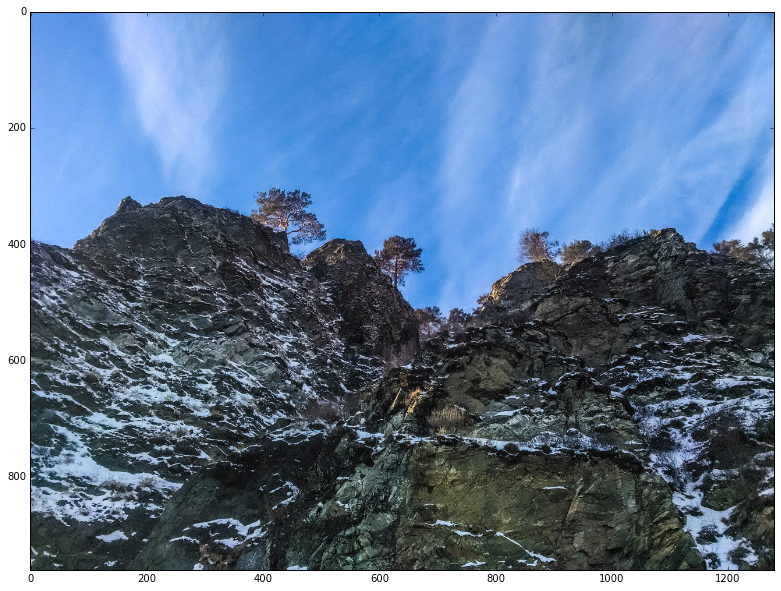

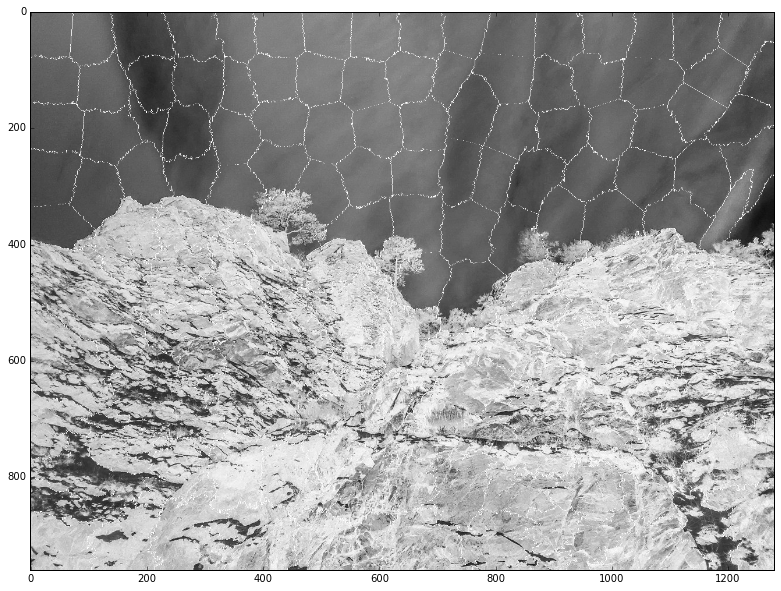

In [36]:
show_img_slic("./Images/05-vQTBnE9Esi4.jpg")